# Deep Neural Network for Image Classification: Application


In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import h5py
from skimage import transform

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['font.family'] = 'DejaVu Sans Mono'

np.random.seed(1)

In [2]:
np.set_printoptions(suppress=True, precision=5)

In [3]:
test = h5py.File('./datasets/test_catvnoncat.h5', 'r')
test.keys()

<KeysViewHDF5 ['list_classes', 'test_set_x', 'test_set_y']>

In [4]:
def load_data():
    test_data = h5py.File('./datasets/test_catvnoncat.h5', 'r')
    test_set_x =  np.array(test_data['test_set_x'][:])
    test_set_y =  np.array(test_data['test_set_y'][:])
#     test_set_y = test_set_y.reshape((-1, 1))

    train_data = h5py.File('./datasets/train_catvnoncat.h5', 'r')
    train_set_x =  np.array(train_data['train_set_x'][:])
    train_set_y =  np.array(train_data['train_set_y'][:])
#     train_set_y = train_set_y.reshape((-1, 1))
    
    labels = np.array(train_data['list_classes'][:])
    
    return train_set_x, train_set_y, test_set_x, test_set_y, labels

In [5]:
train_set_x, train_set_y, test_set_x, test_set_y, labels = load_data()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


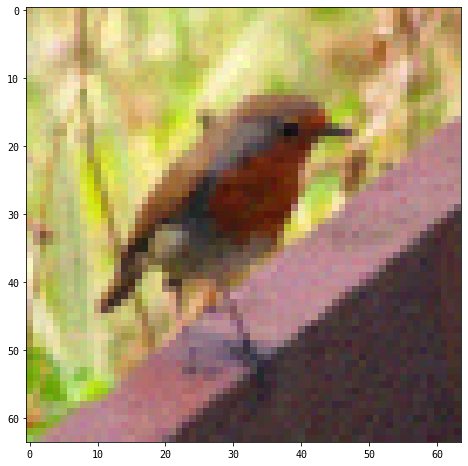

In [6]:
# Example of a picture
index = 10
plt.imshow(train_set_x[index]/255. + np.random.randn(64, 64, 3) * 0.02)

In [7]:
m = train_set_x.shape[0]
X_train, y_train = train_set_x.reshape((m, -1)) / 255., train_set_y
m = test_set_x.shape[0]
X_test, y_test = test_set_x.reshape((m, -1)) / 255., test_set_y

In [8]:
l = []
for x in X_train:
    l.append(x + np.random.randn(12288) * 0.02)
l = np.array(l)
l.shape

(209, 12288)

In [9]:
X_train = np.concatenate((X_train, l), axis=0)


In [10]:
y_train = np.tile(y_train, (2, ))
y_train.shape

(418,)

In [11]:
print('train x: ', X_train.shape)
print('train y: ', y_train.shape)

print('test x: ', X_test.shape)
print('test y: ', y_test.shape)

train x:  (418, 12288)
train y:  (418,)
test x:  (50, 12288)
test y:  (50,)


In [12]:
class Layer:
    def __init__(self, n_input_dims, n_neurons, activation=None, weights=None, bias=None):
        self.weights = weights if weights is not None else np.random.randn(
            n_input_dims, n_neurons) * np.sqrt(1 / n_neurons)
        self.bias = bias if bias is not None else np.random.randn(n_neurons) * 0.1
        self.activation = activation
        self.A = None
        self.dA = None
        self.dZ = None

    def activate(self, X):
        Z = np.dot(X, self.weights) + self.bias
        # 激活函数的输出
        self.A = self._apply_activation(Z)
        return self.A
    
    def _apply_activation(self, Z):
        # 激活函数
        if self.activation is None:
            return Z
        elif self.activation == 'relu':
            return np.maximum(0, Z)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-Z))
        elif self.activation == 'tanh':
            return np.tanh(Z)
        else:
            return Z
    
    def derivative(self, A):
        # 激活函数的导数
        if self.activation is None:
            return np.ones_like(A)
        elif self.activation == 'relu':
            # return np.where(A <= 0, 0., 1.)
            d = np.array(A, copy=True)
            d[A <= 0] = 0.
            d[A > 0] = 1.
            return d 
        elif self.activation == 'sigmoid':
            return A  * (1 - A)
        elif self.activation == 'tanh':
            return 1 - A ** 2
        else:
            return A
    
    def __repr__(self):
        return f"weigths: {self.weights.shape}\n bias: {self.bias.shape}"

In [35]:
NEAR_0 = 1e-10
class DeepNeuralNetwork:
    def __init__(self, lambda_=1e-3, lr=1e-3):
        self.layers = []
        self.lr = lr
        self.lambda_ = lambda_
    
    def add_layer(self, layer):
        self.layers.append(layer)
    
    def feed_forward(self, X):
        for layer in self.layers:
            X = layer.activate(X)
        return X

    def loss(self, y_true, y_preds):
        # 交叉熵误差
        assert(y_true.shape == y_preds.shape)
        term = 0
        for layer in self.layers:
            term += np.sum(layer.weights ** 2)
        loss_ = - y_true* np.log(y_preds + NEAR_0) - (1 - y_true)*np.log(1 - y_preds + NEAR_0)  
        loss_ =  np.mean(loss_, axis=0) + self.lambda_ * term

        return np.squeeze(loss_)
    
    def backpropagation(self, X, y):
        # 反向传播算法 计算每一层的delta 
        # 前向计算 得到输出值
        m = X.shape[0]  # batch size
        out = self.feed_forward(X)  # (m, 1)
        # print(out.shape)
        # loss_ = self.loss(y, out)

        for i in reversed(range(len(self.layers))):  # 从最后一层开始
            layer = self.layers[i]
            if layer == self.layers[-1]:  # 输出层
                # 使用 交叉熵 误差
                assert(y.shape == out.shape)
                layer.dA = -y/(out + NEAR_0) + (1-y) / (1-out + NEAR_0)
                # layer.dA = -y / out + (1-y)/(1-out)  # dL/dA^K  # (m, 1)
                layer.dZ = layer.dA * layer.derivative(out) # dL/dZ^K  (m, 1) (m, 1)
            else:  # 隐藏层
                next_layer = self.layers[i + 1]
                layer.dA = next_layer.dZ @ next_layer.weights.T  # dL/dA^J (m, 1) (1, k)
                # dL/dZ^J (m, k) (m,k)
                layer.dZ = layer.dA * layer.derivative(layer.A)
        
        # 更新参数
        for i in range(len(self.layers)):
            layer = self.layers[i]
            # 上一层的输出 本层的输入
            o_i = X if i == 0 else self.layers[i-1].A
            # weights (I, J)
            # o_i (m, I)
            # dZ (m, J)
            layer.weights -= self.lr *  (o_i.T @ layer.dZ + self.lambda_ * layer.weights) * 1 / m # (I, J)
            layer.bias -=  self.lr * np.sum(layer.dZ) * 1 / m # (J, )

    def train(self, X, y, X_test, y_test, max_epochs=300, batch_size=32):
        y = y.reshape(-1, 1)
        cross_entropy = []
        accuracy = []
        split_size = X.shape[0] // batch_size
        
        for epoch in range(max_epochs):
            for x, y_true in zip(np.array_split(X, split_size), np.array_split(y, split_size)):
                self.backpropagation(x, y_true)
            # self.backpropagation(X, y, learning_rate)
            if epoch % 100 == 0:
                # mse = np.mean(np.square(self.feed_forward(X) - y_onehot))
                loss = self.loss(y, self.feed_forward(X))
                cross_entropy.append(loss)
                
                predict = self.predict(X_train)
                train_acc = np.sum(y_train.ravel()==predict) / len(predict)
                
                predict = self.predict(X_test)
                acc = np.sum(y_test.ravel()==predict) / len(predict)
                accuracy.append(acc)
                print(f'Epoch: {epoch}, cross_entropy: {loss}, train acc: {train_acc}, test acc: {acc}')
        return cross_entropy, accuracy
    
    def predict(self, X):
        y_pred = self.feed_forward(X)
        y_pred = np.where(y_pred >=0.5, 1, 0)
        # out = np.argmax(y_pred, axis=1)
        return np.squeeze(y_pred)

In [36]:
model = DeepNeuralNetwork(lr=0.008, lambda_=1e-4)
model.add_layer(Layer(X_train.shape[1], 64, 'relu'))  # h1  
model.add_layer(Layer(64, 16, 'relu'))  # output
model.add_layer(Layer(16, 4, 'relu'))  # output
model.add_layer(Layer(4, 1, 'sigmoid'))  # output
cross_entropy, accuracy = model.train(X_train, y_train, X_test, y_test, max_epochs=1500, batch_size=64)

Epoch: 0, cross_entropy: 1.9162196461865368, train acc: 0.6555023923444976, test acc: 0.34
Epoch: 100, cross_entropy: 1.8020507173974298, train acc: 0.6555023923444976, test acc: 0.34
Epoch: 200, cross_entropy: 1.6930172997460378, train acc: 0.6555023923444976, test acc: 0.34
Epoch: 300, cross_entropy: 1.6643359814875276, train acc: 0.7703349282296651, test acc: 0.7
Epoch: 400, cross_entropy: 1.5536387973594803, train acc: 0.8588516746411483, test acc: 0.68
Epoch: 500, cross_entropy: 1.5151036017464001, train acc: 0.8803827751196173, test acc: 0.52
Epoch: 600, cross_entropy: 1.477506907933834, train acc: 0.916267942583732, test acc: 0.66
Epoch: 700, cross_entropy: 1.4495929959553115, train acc: 0.9234449760765551, test acc: 0.58
Epoch: 800, cross_entropy: 1.4443403153224046, train acc: 0.9234449760765551, test acc: 0.56
Epoch: 900, cross_entropy: 1.441817706270704, train acc: 0.9234449760765551, test acc: 0.54
Epoch: 1000, cross_entropy: 1.4330812589643425, train acc: 0.928229665071770

In [41]:
old = np.random.rand(4, 3)
old

array([[0.94399, 0.13365, 0.76279],
       [0.63326, 0.17515, 0.23543],
       [0.63215, 0.42214, 0.28185],
       [0.15894, 0.46716, 0.99906]])

In [42]:
new = np.where(old >= 0.5, 1, 0)
new

array([[1, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1]])

In [ ]:
model.layers[-2].bias

In [ ]:
model.layers[-2].weights

In [ ]:
y_pred = model.predict(X_train)
np.sum(y_pred == y_train) / len(y_train)

In [ ]:
plt.plot(cross_entropy)

In [ ]:
plt.plot(accuracy)

In [ ]:
y_pred = model.predict(X_test)
np.sum(y_pred == y_test) / len(y_test)

In [ ]:
def plot_misclassification(test_set_x, y_pred, y_test):
    mis = test_set_x[y_test != y_pred]
    for image in mis:
        plt.figure(figsize=(5, 4))
        plt.imshow(image / 255.)

### 使用Tensorflow 

In [ ]:
import tensorflow as tf 

gpus = tf.config.experimental.list_physical_devices('GPU')
try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

In [ ]:
from tensorflow.keras import layers, Sequential, losses, regularizers

In [ ]:
def process(X, y):
    X = tf.cast(X, dtype=tf.float32) / 255.
    X = tf.reshape(X, (-1, 64*64*3))
    y = tf.cast(y, dtype=tf.int32)
    return X, y

In [ ]:
train_db = tf.data.Dataset.from_tensor_slices((train_set_x, train_set_y))
test_db = tf.data.Dataset.from_tensor_slices((test_set_x, test_set_y))
train_db = train_db.shuffle(1000).batch(64).map(process)
test_db = test_db.shuffle(1000).batch(64).map(process)

In [ ]:
x, y = next(iter(train_db))

In [ ]:
x.shape, y.shape

In [ ]:
lambda_ = 1e-2

In [ ]:
network = Sequential([
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(lambda_)),
#     layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(lambda_)), 
#     layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l2(lambda_)), 
    layers.Dense(1, activation='sigmoid'),
])
network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = network.fit(train_db, epochs=150, validation_data=test_db, validation_freq=10)

In [ ]:
y_pred = network.predict_classes(X_test)
np.sum(np.squeeze(y_pred) == np.squeeze(y_test)) / len(y_test)

In [ ]:
plot_misclassification(test_set_x, y_pred.ravel(), y_test.ravel())